In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

In [2]:
torch.set_default_dtype(torch.float64)

**Class: OU processes**

In [3]:
class OU_vector:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN, D, timegrid='True'):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha

        """
            check whether every element in sigma is positive
        """
        assert all(beta > 0), "beta should be positive"    
        self.beta = beta
        assert all(sigma > 0), "variance should be positive"
        self.sigma = sigma
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
                Make sure to match the dimension of each object;
                    note that memoryview of torch/python object flattens
        """
        output = torch.empty(self.pts.shape)
        output[:, 0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        for t in range(1, self.pts.shape[1]):
            dt = interval[:, t-1].reshape(-1, 1)
            mean = self.alpha + (output[:, t-1].reshape(-1,1) - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean.flatten(), cov = torch.diag(var.flatten())))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
        return output, interval

In [4]:
D = 2

In [5]:
alpha = torch.tensor(10.).repeat(D, 1)
beta = torch.tensor([1.,2.]).reshape(-1,1)
z0 = torch.randn((D, 1))
sigma = torch.tensor(1.).repeat(D,1)

**Note that the diffusion simulation based on Euler-Maruyama results in very smooth plot once dt > 2.**

In [6]:
true_sde = OU_vector(t0 = 3., t1 = 4., z0 = z0, alpha = alpha, beta = beta, sigma = sigma, dN=300, D = D, timegrid='True')

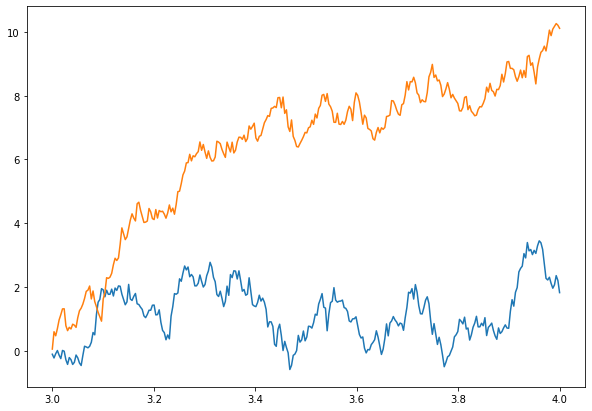

In [7]:
plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T)
plt.show()

Variational inference: KL

In [8]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        # Hyperparameter
        sigma = self.ou.sigma
        
        # Parameters
        assert all(beta > 0), "beta should be positive"
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the likelihood based on the transition density of the (simulated) path
            """
#             print("sigma = ", sigma.shape, "beta = ", beta.shape, "dt = ", dt.shape)
#             print("log sigma = ", torch.log(sigma), "log beta = ", torch.log(beta), "rest = ", torch.log(1 - torch.exp(-2 * beta * dt)) )
            term1 = -0.5 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = beta * (X[:, 1:] - alpha - (X[:, :-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))
#             print("term1 = ", term1, "term2 = ", term2, "term3 = ", term3)
            return torch.sum(term1 - term2/term3, axis=1)
        
        LL = compute_transition(X, dt, alpha, beta, sigma)
#         print(LL.data.numpy())
#         print("D = ", self.ou.D)
        LL.backward(torch.tensor([1.]).repeat(self.ou.D))
         
        return {"alpha": alpha.grad.detach().clone(), 'beta':beta.grad.detach().clone(), "LL": LL.data.numpy()}


In [9]:
alpha_ = torch.randn((2, 1))
beta_ = torch.tensor([5., 5.]).reshape(-1,1)


learning_rate = 0.05

for i in range(10000):
    lr = 0.1
    mle = Score(true_sde)
    update = mle.compute_score(alpha = alpha_, beta=beta_)
    
    alpha_ += learning_rate * update['alpha']
    beta__ =  beta_ + learning_rate * update['beta']
    
    
    while any(beta__ < 0):
        for d in range(beta_.shape[0]):
            if beta__[d] < 0:
                while beta__[d] < 0:
                    beta__[d] = beta_[d] + lr * update['beta'][d]
                    lr *= 0.5
    beta_ = beta__
    if i % 1000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'LL = ', update['LL'])

beta =  [[4.84283733]
 [1.78991131]] alpha =  [[ 1.70486853]
 [10.38591292]] LL =  [-2119.7558567  -2360.79229241]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL =  [-2111.47584668 -1534.12165849]
beta =  [[1.44656765]
 [2.39006823]] alpha =  [[ 2.52664245]
 [10.5739995 ]] LL 

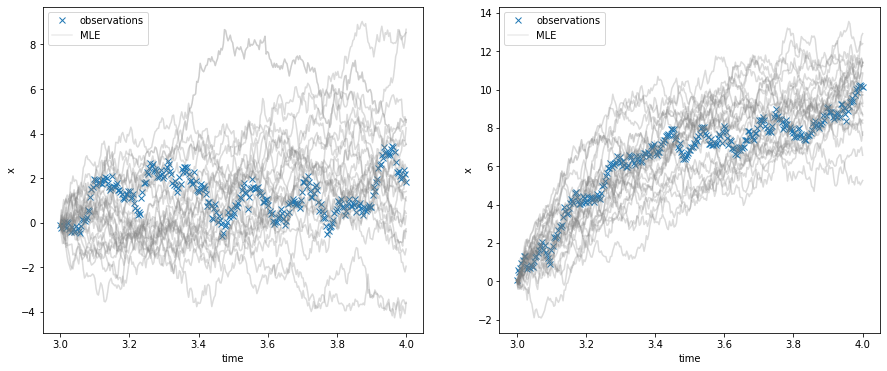

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
# plt.title("Fitted Process: MLE")
for j, ax in enumerate(ax.ravel()):
    ax.plot(true_sde.pts[j], true_sde.trj[j], 'x', label='observations')
    for i in range(25):
        vi = OU_vector(t0 = 3., t1 = 4., z0 = z0, alpha = alpha_, beta = beta_, sigma = sigma, dN=300, D = D, timegrid='True')    
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        if i == 24:
            ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey', label='MLE')
    ax.set_xlabel("time")
    ax.set_ylabel("x")
    ax.legend()
plt.show()

In [11]:
print("True alpha = \n", alpha.data.numpy(), "\nAlpha_MLE = \n", alpha_.data.numpy(), "\nTrue Beta = \n", beta.data.numpy(), "\nBeta_MLE = \n", beta_.data.numpy())

True alpha = 
 [[10.]
 [10.]] 
Alpha_MLE = 
 [[ 2.52664245]
 [10.5739995 ]] 
True Beta = 
 [[1.]
 [2.]] 
Beta_MLE = 
 [[1.44656765]
 [2.39006823]]


In [104]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma =  ou.alpha, ou.beta, ou.sigma
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = lambda z: (1 - beta ** 2) * (z ** 2) + (2 * alpha * beta ** 2 + ((beta - 1) * sigma ** 2)) * z
        
        num = func_kl(self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma**2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        
        D = self.ou.D
        z0 = self.ou.z0
        z1 = self.ou.trj[:, -1].reshape(D, 1)
        """
            t is tensor
        """
        t0 = self.ou.t0.repeat(D, 1)
        t1 = self.ou.t1.repeat(D, 1)
        
        # Obtain the rest 
        def A(u):
            return (beta - 1) * (u ** 2) / (2 * sigma ** 2)  - alpha * beta * u / sigma ** 2
        
        return A(z1) - A(z0) + 0.5 * (t1 - t0) * alpha * beta * (1 + alpha * beta / sigma ** 2)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
        
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [70]:
obs_sigma = 0.02

In [71]:
alpha = torch.tensor([1.])
beta = torch.tensor([2.])
z0 = torch.tensor([10.])
sde_sigma = torch.tensor([1.])

In [72]:
true_sde = OU_vector(t0 = 3., t1 = 4., z0 = z0, alpha = alpha, beta = beta, sigma = sde_sigma, dN=100, D = 1, timegrid='True')

In [106]:
# Observations with Gaussian noise
obs = torch.from_numpy(np.random.normal(loc = true_sde.trj[0][::11], scale = obs_sigma))
obs_time = true_sde.pts[0][::11]

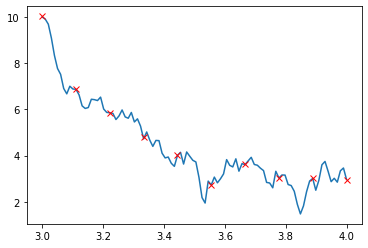

In [107]:
plt.plot(true_sde.pts.T, true_sde.trj.T)
plt.plot(obs_time, obs, 'rx')

In [76]:
import tqdm as tq

Black box variatioanl inference for SDE

In [145]:
D = 100
S = 80

# If learning rate is high, then beta explodes
learning_rate = 0.000001
lr = learning_rate
IT = 200
dN = 30
z0 = torch.tensor(obs[0])

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT))
KL_traces = np.empty((len(obs_time) -1 , IT))
NLL_traces = np.empty((len(obs_time) -1 , IT))
pars_traces = np.empty((2, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([1.])
    beta_ = torch.rand(1)
    for i in range(IT):
        
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        
        # Compute (negative) ELBO
        if i > 0:
            vi_ = OU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, dN=dN, D=D, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = OU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, dN=dN, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D)
        
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
#         if torch.nanmean(f_of_X) > 1e+6:
#             beta_ -= 0.0000001 * beta_grad
#             alpha_ -= 0.0000001 * alpha_grad
#             r__ = r_ - 0.0000001 * r_grad
#         else:
        beta__ = beta_ - learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while any(beta__ < 0):
            for d in range(beta_.shape[0]):
                if beta__[d] < 0:
                    while beta__[d] < 0:
                        beta__[d] = beta_[d] + lr * update['beta'][d]
                        lr *= 0.5
        beta_ = beta__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()

        
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = OU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), alpha = alpha_, beta = beta_, sigma = sde_sigma, D = S, dN = dN, timegrid='False')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_14482/4113866500.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z0 = torch.tensor(obs[0])
  0%|                                                     | 0/9 [00:00<?, ?it/s]

alpha =  [0.98999994] beta =  [0.91509376]
(Neg) elbo =  8713.17255426487
alpha =  [0.57298845] beta =  [2.97486829]
(Neg) elbo =  1697.9783919379747
alpha =  [0.43221016] beta =  [3.48203989]
(Neg) elbo =  1250.0122802756205
alpha =  [0.43890232] beta =  [3.62362787]
(Neg) elbo =  1392.1659131139093


 11%|█████                                        | 1/9 [00:10<01:21, 10.21s/it]

alpha =  [0.99975673] beta =  [0.30379005]
(Neg) elbo =  2430.3699969277973
alpha =  [0.94298548] beta =  [1.01817305]
(Neg) elbo =  2441.7197375427604
alpha =  [0.90395624] beta =  [1.40052124]
(Neg) elbo =  1603.1531864409442
alpha =  [0.8959415] beta =  [1.60903928]
(Neg) elbo =  1977.564417942714


 22%|██████████                                   | 2/9 [00:20<01:11, 10.23s/it]

alpha =  [0.99785255] beta =  [0.69956308]
(Neg) elbo =  2345.325940855304
alpha =  [0.94301294] beta =  [1.14425766]
(Neg) elbo =  1525.147305337602
alpha =  [0.90811996] beta =  [1.44445521]
(Neg) elbo =  1971.9897953174718
alpha =  [0.91081663] beta =  [1.621329]
(Neg) elbo =  1177.2623022057319


 33%|███████████████                              | 3/9 [00:31<01:02, 10.41s/it]

alpha =  [1.00044532] beta =  [0.74871341]
(Neg) elbo =  2064.996109721751
alpha =  [0.93781716] beta =  [1.18693279]
(Neg) elbo =  1891.3031047316147
alpha =  [0.89331802] beta =  [1.49829611]
(Neg) elbo =  1745.6203269044083
alpha =  [0.85294544] beta =  [1.77719131]
(Neg) elbo =  1668.5032766382758


 44%|████████████████████                         | 4/9 [00:41<00:51, 10.32s/it]

alpha =  [0.99665208] beta =  [0.77732363]
(Neg) elbo =  3231.2598803293263
alpha =  [0.80680006] beta =  [1.50288954]
(Neg) elbo =  2287.808084909784
alpha =  [0.57811764] beta =  [2.09292436]
(Neg) elbo =  2316.0276187568375
alpha =  [0.36008441] beta =  [2.57248058]
(Neg) elbo =  1826.8118619234394


 56%|█████████████████████████                    | 5/9 [00:51<00:41, 10.30s/it]

alpha =  [1.00139885] beta =  [0.2642817]
(Neg) elbo =  2264.1490947233333
alpha =  [1.03835199] beta =  [0.22121486]
(Neg) elbo =  2634.2808312143816
alpha =  [1.0692298] beta =  [0.19538977]
(Neg) elbo =  1943.0301427580248
alpha =  [1.09497324] beta =  [0.18712003]
(Neg) elbo =  2250.9406675445043


 67%|██████████████████████████████               | 6/9 [01:02<00:31, 10.50s/it]

alpha =  [1.00010691] beta =  [0.11476423]
(Neg) elbo =  1740.9238332906277
alpha =  [1.00999087] beta =  [0.23976584]
(Neg) elbo =  2367.681139556707
alpha =  [1.02621685] beta =  [0.36518049]
(Neg) elbo =  2040.1258598671411
alpha =  [1.04981653] beta =  [0.47141996]
(Neg) elbo =  2632.1901678295985


 78%|███████████████████████████████████          | 7/9 [01:13<00:21, 10.54s/it]

alpha =  [1.00167768] beta =  [0.72514085]
(Neg) elbo =  2359.6937134623663
alpha =  [1.08155583] beta =  [0.78739756]
(Neg) elbo =  2200.2596705390124
alpha =  [1.17367988] beta =  [0.87240151]
(Neg) elbo =  2318.532641000907
alpha =  [1.2672442] beta =  [0.93772821]
(Neg) elbo =  2350.4094747794948


 89%|████████████████████████████████████████     | 8/9 [01:23<00:10, 10.45s/it]

alpha =  [1.0009261] beta =  [0.4948536]
(Neg) elbo =  2221.413159128203
alpha =  [1.03237048] beta =  [0.63666216]
(Neg) elbo =  1705.4854663065205
alpha =  [1.07446493] beta =  [0.75869312]
(Neg) elbo =  1996.1863914766197
alpha =  [1.13356122] beta =  [0.85623023]
(Neg) elbo =  2135.3686800431537


100%|█████████████████████████████████████████████| 9/9 [01:33<00:00, 10.43s/it]


Trace plot: ELBO

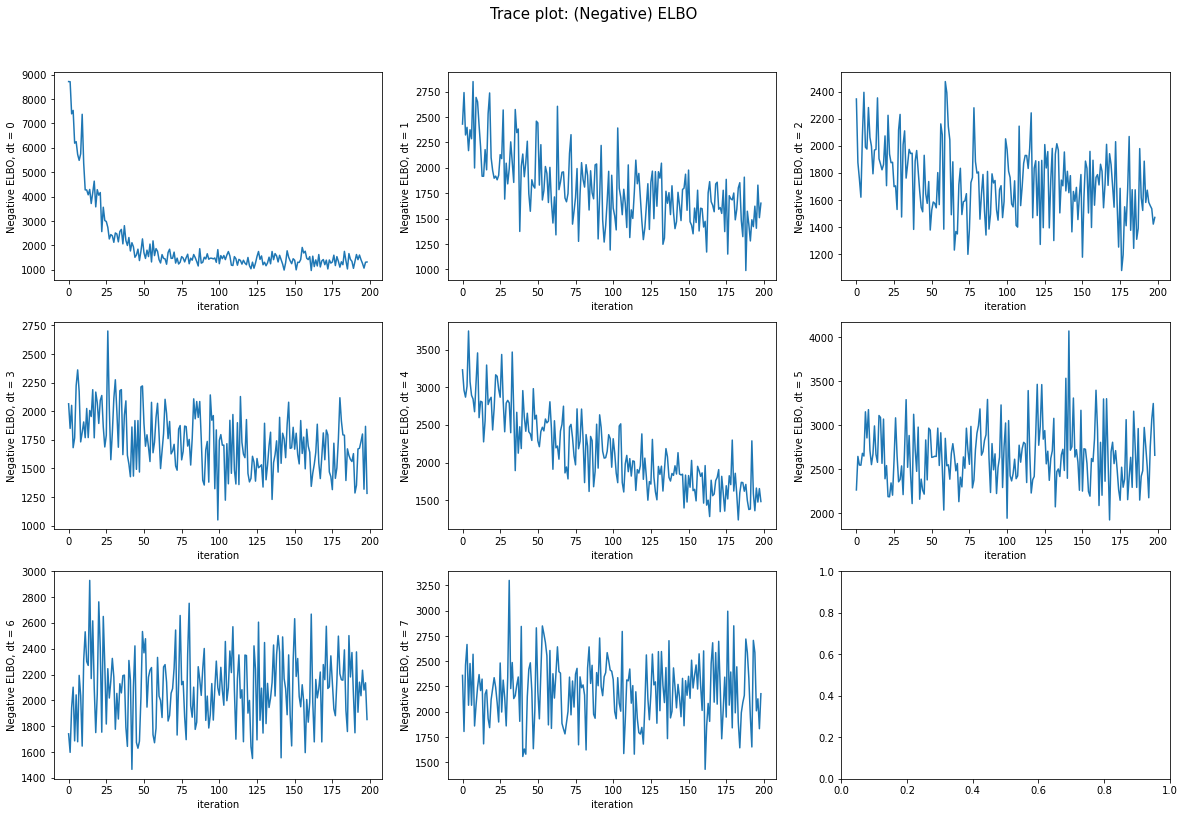

In [146]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :-1])), elbo_traces[t, :-1])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

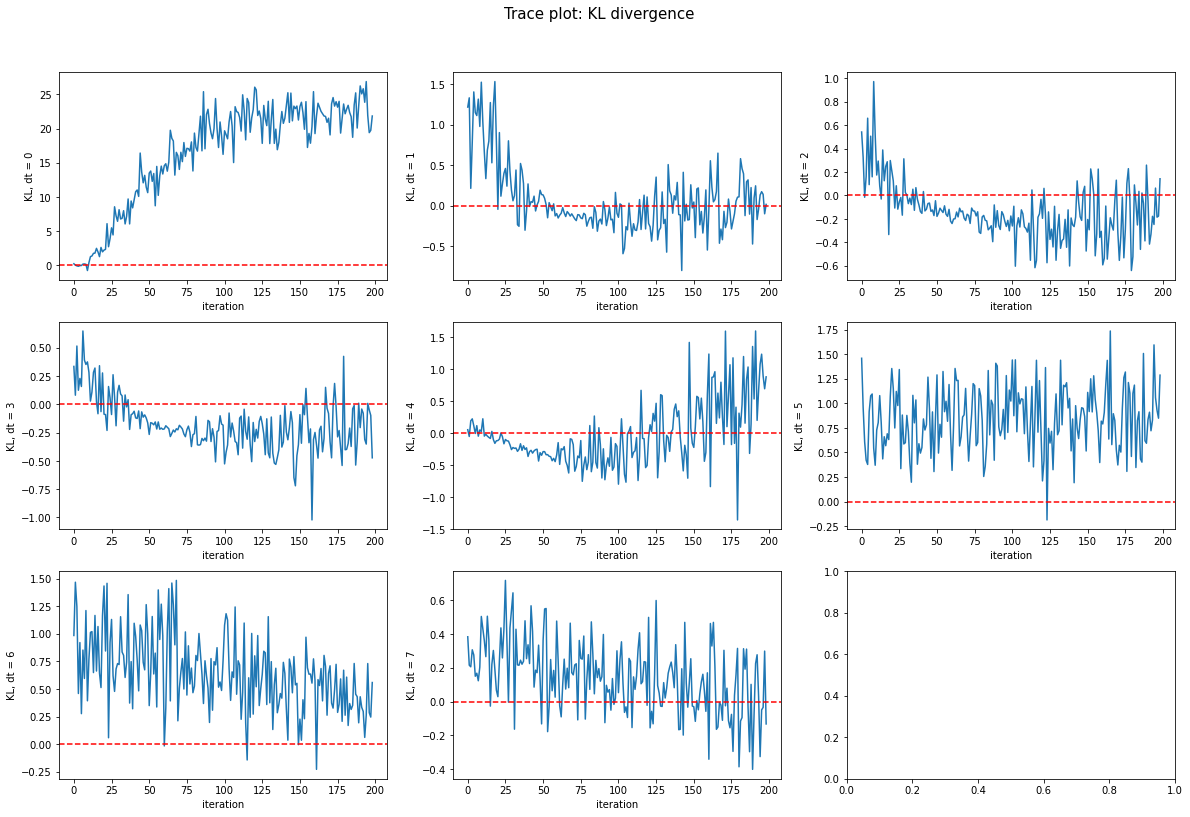

In [147]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :-1])), -1 * KL_traces[t, :-1])
    ax.axhline(0, color='red', linestyle='dashed')
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

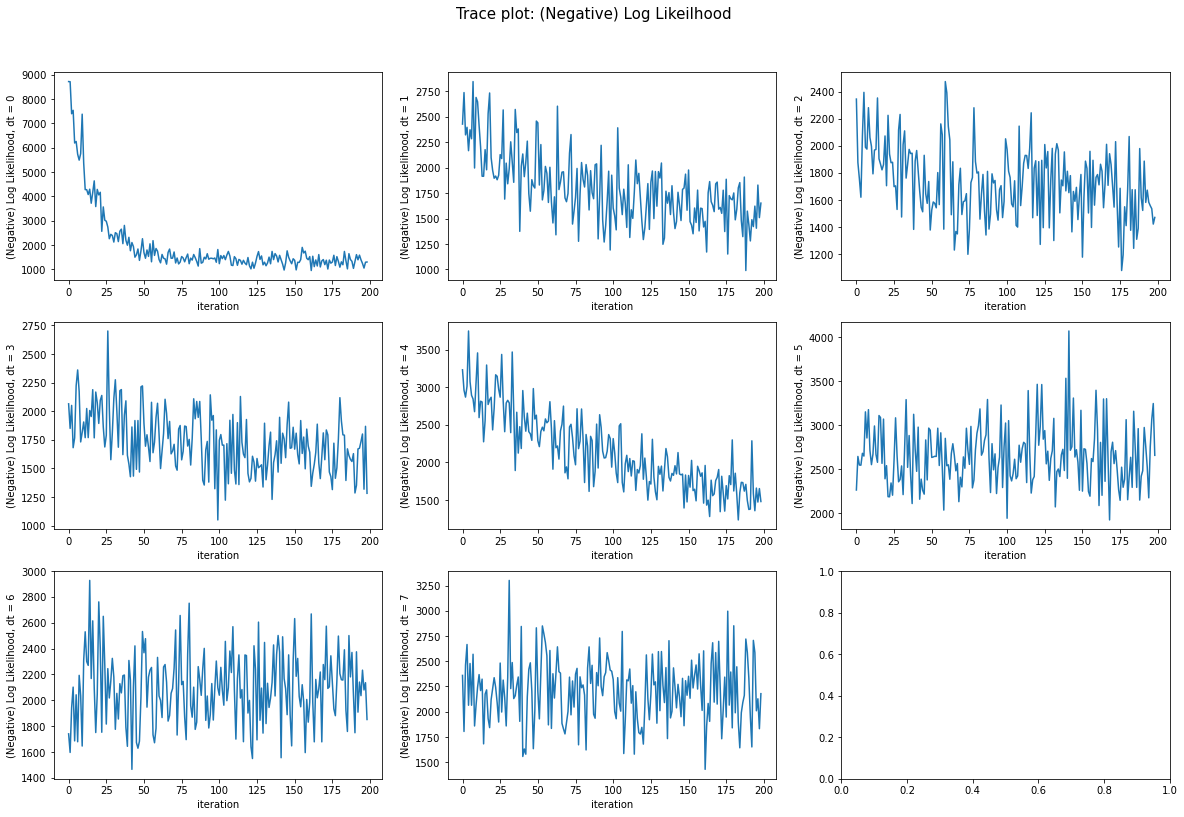

In [148]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(NLL_traces[t, :-1])), -1 * NLL_traces[t, :-1]) 
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

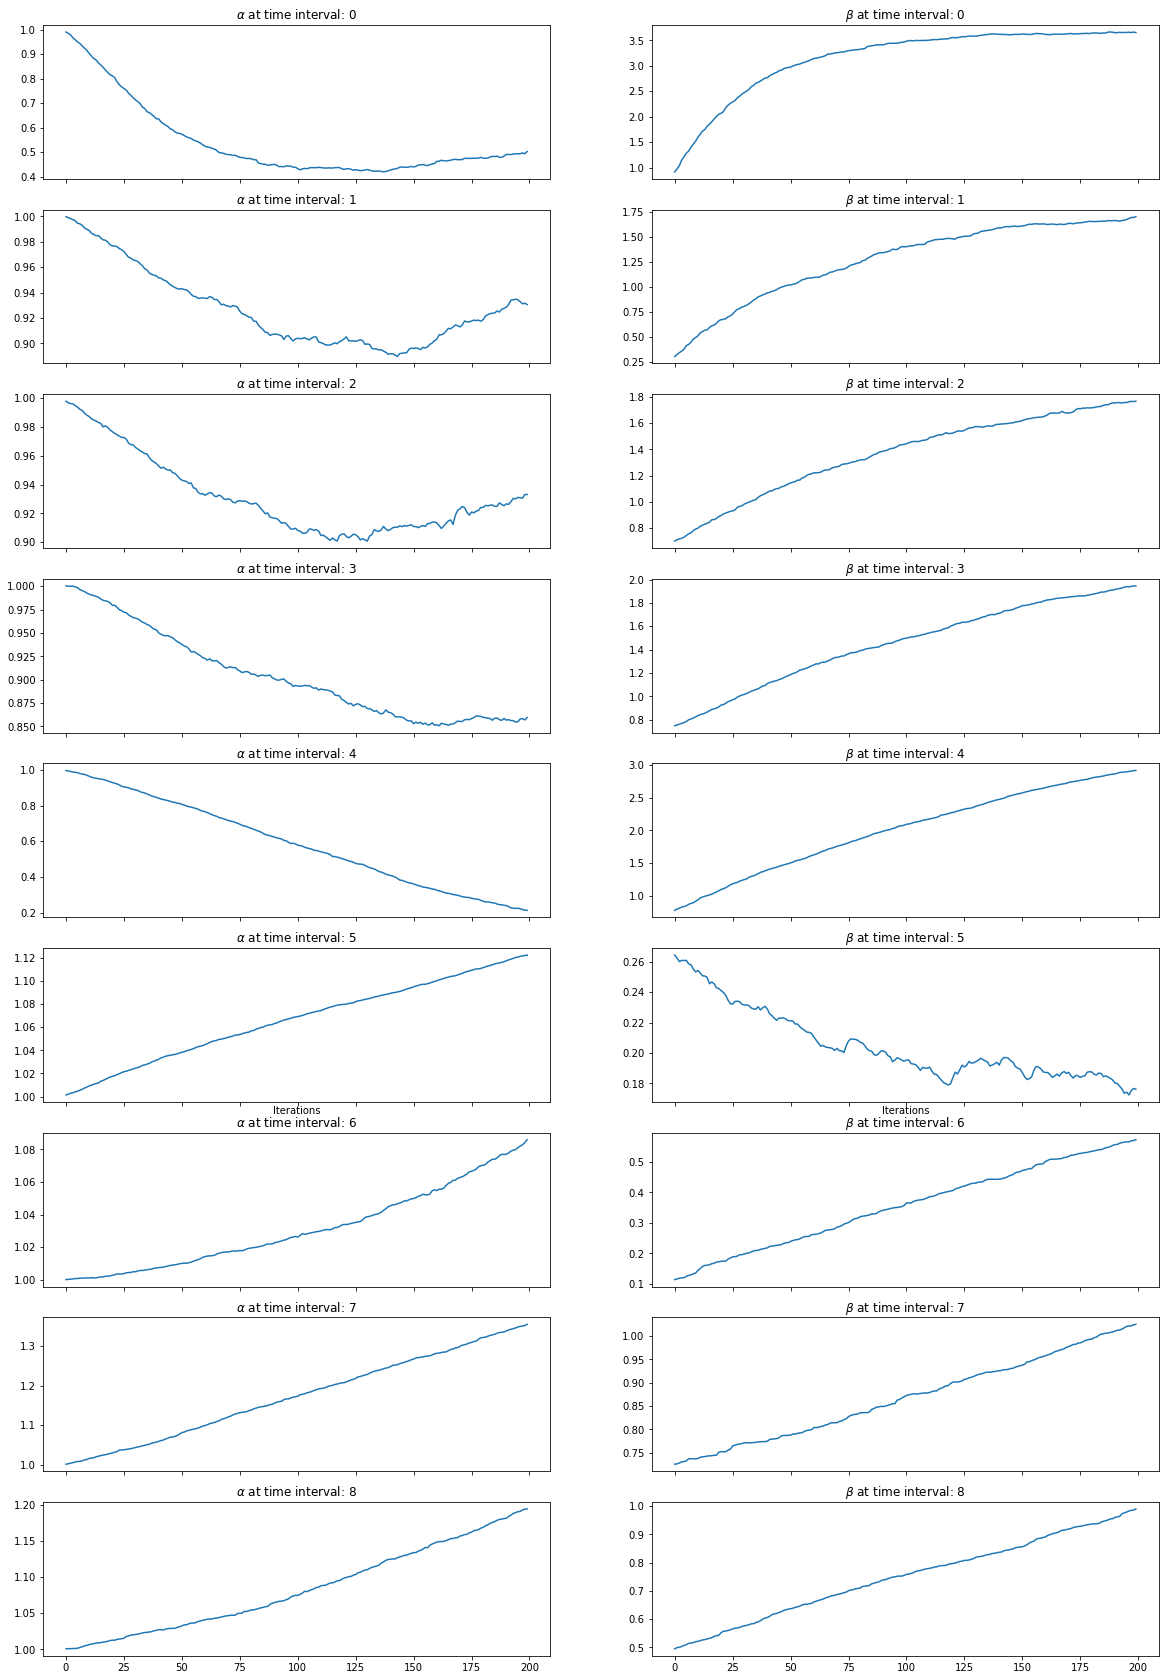

In [149]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=2, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$\beta$']
for j, ax in enumerate(ax.ravel()):
    i = j % 2
    t = j // 2
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

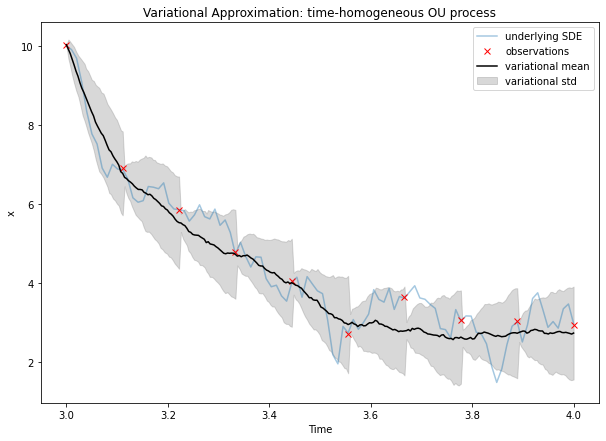

In [150]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts[0], true_sde.trj[0], label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(3, 4, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-homogeneous OU process")
plt.show()

Examine whether the estimator of the KL divergence is always positive;

(NEED TO REVISIT)

In [ ]:
D = 50
alpha = torch.tensor([1.]).repeat(D, 1)
beta = torch.tensor([2.]).repeat(D, 1)
sigma = torch.tensor([1.]).repeat(D, 1)
z0 = torch.tensor([0.]).repeat(D, 1)

In [ ]:
true_sde = OU_vector(t0 = 0., t1 = 1., z0 = z0, alpha = alpha, beta = beta, sigma = sigma, dN=300, D = D, timegrid='True')
elbo = ELBO(true_sde)

In [ ]:
plt.plot(true_sde.pts.T, true_sde.trj.T)
plt.show()